# A mini investigation into the PM10 pollution levels in Seoul, South Korea

![](https://img.hani.co.kr/imgdb/resize/2019/0115/154745436225_20190115.JPG)
*Image taken from [Hankyoreh](http://english.hani.co.kr/arti/english_edition/e_national/878321.html)*

It is no secret that many Asian cities are heavily polluted. In fact, according to [this](https://www.eco-business.com/news/of-the-worlds-100-most-polluted-cities-99-are-in-asia/) article from last year, a whopping 99 out of the world's 100 most polluted cities were in Asia. The last few decades have seen rapid urbanization of countries such as India and China, and if we pair this with the relatively relaxed regulation compared to that of Europe and North America, rampant pollution is rather unsurprising.

In this notebook, I will take a small look into the levels of PM10 pollution within the South Korean capital. The dataset I am working with contains pollution levels for several other pollutants, but this notebook will be focusing purely on PM10 (this is the first Kaggle project I have done alone so I wanted to take it fairly easy- perhaps once my skills improve I will return and investigate the other pollutants too).


**What is PM10?**

The PM in PM10 stands for "Particulate Matter." The 10 stands for the 10 micrometer or less diameter of these particles. For scale, an average strand of human hair is about 50-70 micrometers in diameter. If we expose ourselves to a large amount of these particles regularly, the health effects can be severe. Small particles such as these can lead to respiratory issues such as asthma attacks or bronchitis, and can even cause premature death.

There does exist an even worse categorization of particulate matter, known as PM2.5. As the name suggests, these are particles that are 2.5 micrometers or less in diameter, and this smaller size allows them to more easily infiltrate our lungs and bloodstream.

Without further ado, let's dive into the data.

In [ ]:
# Here we are importing all the standard packages/libraries necessary to take a look at our data

import json
import numpy as np
import pandas as pd
import folium
from folium import Choropleth
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Understanding our data

The dataset we're working with has been accrued from 25 physical locations within Seoul (one per "gu" district. You can think of a "gu" district as a borough in London). Each location took a pollutant reading every hour from the beginning of 2017 until the end of 2019.

In [ ]:
# It's always a good idea to take a glimpse of the data we're working with.

df = pd.read_csv("../input/air-pollution-in-seoul/AirPollutionSeoul/Measurement_summary.csv")
df.head()

In [ ]:
# Since I'm only going to be investigating PM10 data, I'll delete the columns containing data for other pollutants. 

unwantedPollutants = {"SO2", "NO2", "O3", "CO", "PM2.5"}
df.drop(unwantedPollutants, axis=1, inplace=True)

# 1. Lineplot

In [ ]:
# The first thing I wanted to do was create a simple linegraph showing the average PM10 levels for the entire city on a monthly basis.
# In order to achieve this, we'll create a new dataframe called lineplot_df and create a few new columns to help us better organise the data.

lineplot_df = pd.read_csv("../input/air-pollution-in-seoul/AirPollutionSeoul/Measurement_summary.csv", index_col="Measurement date", parse_dates=True)
lineplot_df.drop(unwantedPollutants, axis=1, inplace=True) # Since we created a new dataframe straight from the CSV file rather than copying the main one, we'll delete the other pollutant data again

lineplot_df["Year"] = lineplot_df.index.year
lineplot_df["Month"] = lineplot_df.index.month

# To obtain the monthly average throughout the entire three year period, I'll create a new column that includes both the month and year.
# I'll then group the data by this new column and extract the mean value for each month

lineplot_df["Year and Month"] = lineplot_df[["Year", "Month"]].astype(str).agg("-".join, axis=1)
lineplot_df["PM10avg"] = lineplot_df.groupby(["Year and Month"]).PM10.transform("mean")

In [ ]:
# We'll take another quick peek at the data to make sure everything's gone smoothly.

lineplot_df.head()

In [ ]:
lineplot_df.shape

In [ ]:
# As shown from the above, we've got many unnecessary rows where the PM10 average value has been duplicated. We only really need 36 rows (12 months * 3 years).
# We'll delete all the rows which contain a duplicate value in the "Year and Month" column, as we only need one value for each month.

lineplot_df.drop_duplicates(subset="Year and Month", inplace=True)

In [ ]:
# Much better! We now only have the 36 rows we need.

lineplot_df.shape

In [ ]:
# Time to plot our linegraph.

ax = plt.figure(figsize=(20,10), constrained_layout=True)
ax.suptitle("Average PM10 for all districts (2017-2019)", fontsize=20, fontweight="bold")
lp = sns.lineplot(x=lineplot_df["Year and Month"], y=lineplot_df["PM10avg"], sort=False)
lp.set_ylabel("Average PM10", fontsize=20)
lp.set_xlabel("Year and Month", fontsize=20)
lp.set_xticklabels(lineplot_df["Year and Month"].values, rotation=40, ha="right")
plt.show()

**Lineplot observations**

We can instantly see from the above graph that PM10 levels rise in the winter and spring, and fall during the summer and autumn. The pattern is far too prevalent to be a coincidence. This piqued my curiosity, so I did some googling and found that this is apparently caused by two main factors: the increased energy demand during the winter (cooler temperatures means more energy being consumed in order to stay warm), and, quoting from [this](https://www.kent.co.in/blog/winter-and-air-pollution-why-does-air-quality-deteriorate-as-temperature-drops/) website, "During summer, the lowest layer of the atmosphere is warmer and lighter as compared to winter, which makes it easy for air to rise upwards. As a result, the pollutants are carried away from the ground."

# 2. Folium map

Let's now create a map to see where the data stations are located. I'll also create a new dataframe and a new column showing the average PM10 levels per station/address (this is what PM10addavg means) over the three year period of our data. This will let us see which areas of Seoul have the highest concentrations of PM10.

In [ ]:
folium_df = df.copy()

folium_df["PM10addavg"] = folium_df.groupby("Address").PM10.transform("mean")
folium_df.drop_duplicates(subset="Address", inplace=True)

In [ ]:
# Making sure it all went smoothly. We should expect to have 25 rows given the 25 unique districts we've got data from.

folium_df.shape

In [ ]:
folium_df.head()

In [ ]:
# All looks good, time to create the map

m = folium.Map(
    location=[37.5326, 127.0246], # These are the rough coordinates of Seoul
    zoom_start=12
)

for i, row in folium_df.iterrows():
    folium.Marker([row.Latitude, row.Longitude], tooltip="Address: {}.<br> PM10: {}".format(row.Address, row.PM10addavg)).add_to(m)
    
m

**Marker map observations**

In all honesty, this map is rather bland and it's very tedious to have to move your mouse cursor over each marker to see the data.
Let's take this map to the next level by creating a choropleth map instead.

# 3. Choropleth map

In [ ]:
# The first thing we need in order to create a choropleth map is data that tells us the boundaries of each district.
# I obtained a GeoJSON file containing such data from a GitHub repository (you can find this at the bottom of the paragraph beneath the map).

with open("../input/seouljson/seoul_municipalities.json", "r") as file:
    district_borders = json.loads(file.read())

test_map = folium.Map(
    location=[37.5326, 127.0246], 
    zoom_start=12)

Choropleth(geo_data=district_borders).add_to(test_map)

for i, row in folium_df.iterrows():
    folium.Marker([row.Latitude, row.Longitude], tooltip="Address: {}.<br> PM10: {}".format(row.Address, row.PM10addavg)).add_to(test_map)

test_map

**Test map obversations**

The map already looks more interesting than the previous, and we haven't even added any PM10 data to the choropleth side of things yet. 

One observation we can already make is that the locations of some of the data stations are somewhat unrepresentative of their district. 
For example, if we look at the station in the centremost district (Address: 136, Hannam-daero, Yongsan-gu), we can see that the station is located in the very northeast corner of the district rather than towards the centre. In fact, it's virtually on the borderline between two other districts. 

Additionally, if we look at the station towards the southwest (Address: 14, Sillimdong-gil, Gwanak-gu), despite the majority of the district being physically situated south of the district above, the data station is actually *further north* than that of the above district.

*The GitHub where I obtained the GeoJSON data is [here](https://github.com/southkorea/seoul-maps)

**Setting up our final map**

So, we're now going to add the relevant PM10 data to our choropleth map. This will light the map up with pretty colours rather than it being a giant blue blob, and will allow us to visually see which areas of Seoul are the most polluted with PM10.

The first thing we need to do is create a pandas dataframe that contains the name of each district while, and this is **very** important, making sure the index follows the exact same naming convention for each district used by the GeoJSON file. If they are at all different, the code won't know which data to allocate to each district within the choropleth map.

Let's dive into the raw GeoJSON data to find this naming convention.

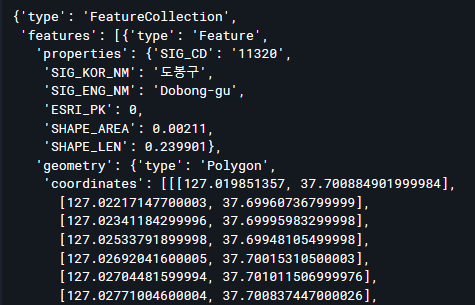

**Obtaining the GeoJSON data district naming convention**

I originally included a dump of the entire raw GeoJSON data here, but upon sharing and viewing the notebook I realised just how much unnecessary space it took up. I think it took me about 10 seconds of pure scrolling to reach the bottom. I've now updated this with a simple screenshot of the data we're looking for.

If we look at the fifth row of the data above, we can find the naming convention we need to use after the "SIG_ENG_NM" heading.

"SIG_ENG_NM": "Dobong-gu"

The GeoJSON data has each station listed as "xyz-***gu***".

Let's take a quick look at our main dataframe again.

In [ ]:
df.head()

We can see from the above that while the "xyz-gu" portion of the address is indeed included within the addresses we have, it's buried in the middle of other data that we don't really want. We don't want "19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republic of Korea", we only want the "Jongno-gu" portion.

What we'll do is extract all of the names from the GeoJSON file, then we'll create a new column in our dataframe to allocate these names to their respective addresses.

Let's create a regular expression so we can quickly extract all the data we need.

In [ ]:
# First we must import the necessary package.

import re

# We know that, conveniently, the data we're looking for all ends with "gu." We can easily create a regular expression that trawls through the entire GeoJSON block of text and extracts only the phrases which satisfy the above condition.

districtsRegex = re.compile(r"""[a-zA-Z.+]+-gu""")
gu_districts = districtsRegex.findall(json.dumps(district_borders))
print(gu_districts)

Success! With only this tiny amount of code we searched though a document containing over 1,500,000 characters and extracted the precise 25 words we needed.

The next step is to put the names we've extracted into a dataframe. I'll create a new dataframe for our choropleth map, and will add a new blank column called "name_eng."

In [ ]:
choro_df = folium_df.copy()
choro_df["name_eng"] = ""

# As we established earlier, all of the district names used in the GeoJSON file are located within the addresses already present in our dataframe.
# We'll now iterate through our new dataframe and allocate each row with its respective GeoJSON district name. 

for i, row in choro_df.iterrows():
    for gu in gu_districts:
        if gu in row.Address:
            choro_df.at[i, "name_eng"] = gu

In [ ]:
# Let's take a look at our new dataframe to make sure the names were allocated correctly. The "name_eng" column should now be populated.
# It looks like everything has gone smoothly!

choro_df

In [ ]:
# The last thing we must do is set the index of our dataframe as the naming convention used in the GeoJSON file.
# This is because, as you'll soon see below, the "key_on" we'll use when creating the choropleth map will be the "SIG_ENG_NM" property from the GeoJSON data.
# If you remember from earlier, the "SIG_ENG_NM" property is where names such as Jongno-gu, Dongdaemun-gu and Gangnam-gu were found. We're making our index match these names.

choro_df.set_index(choro_df["name_eng"], inplace=True)

In [ ]:
# Why not take one last look at our new dataframe just to make sure the new index is all good.

choro_df

Perfect, the index is now exactly how we want it. The data might look a bit odd as we've still got the "name_eng" column that is now identical to the index, but we could easily get around this by deleting the column. We won't worry about that for now since it has no detrimental effect on the map we're about to make. The "PM10" and "Measurement date" columns are also unnecessary as we're not really investigating individual readings nor how the values change over time, we're taking a look at the average readings of PM10 across each district during 2017-2019. The only column we need for this is the "PM10addavg" column. Again, however, the aforementioned columns won't affect the map at all so we'll leave them there for now.

Now that we've made the necessary preparations, we can finally create our final choropleth map.

In [ ]:
m_2 = folium.Map(
    location=[37.5326, 127.0246],
    zoom_start=12
)

Choropleth(geo_data=district_borders,
          data=choro_df["PM10addavg"],
          key_on="feature.properties.SIG_ENG_NM",
          fill_color='YlGnBu').add_to(m_2)

for i, row in choro_df.iterrows():
    folium.Marker([row.Latitude, row.Longitude], tooltip="Station: {}.<br>PM10 Average: {}".format(row.Address, row.PM10addavg)).add_to(m_2)
    

m_2

**Choropleth map observations**

So there it is, our final map. This one is certainly the most informational while also being more aesthetically pleasing. There is a legend in the top-right corner. I always assumed that city centres would be the most polluted, but this data tells us otherwise. The centremost districts appear relatively cleaner than those on the outside, at least with regards to PM10. 

# Conclusion

**So, just how bad is the air in Seoul?**

Let's take a look at the below guidelines taken from the [UK Government website.](https://uk-air.defra.gov.uk/air-pollution/uk-eu-limits)

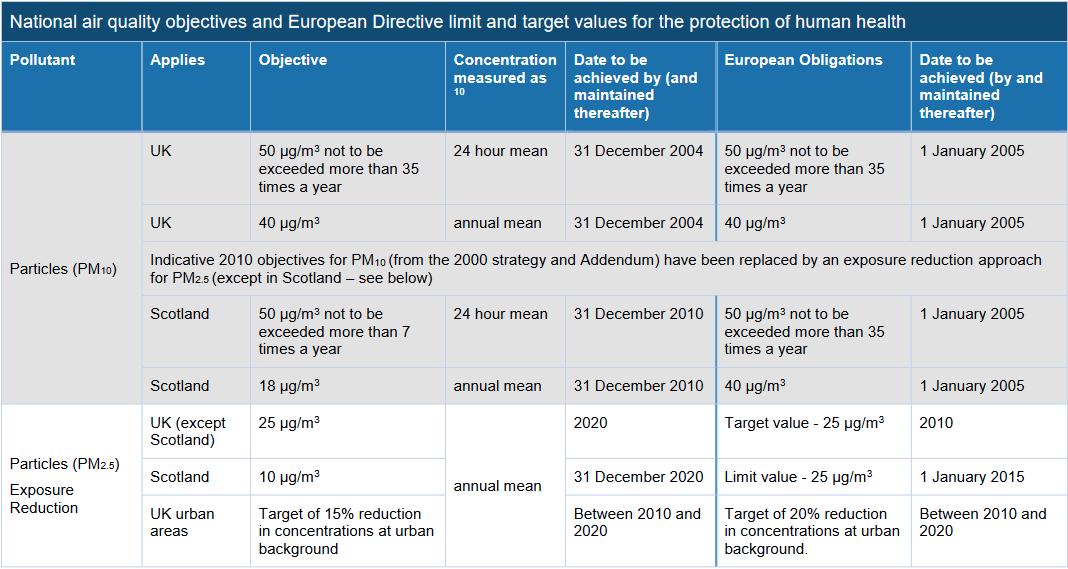


It seems that the UK and EU are striving to maintain annual mean PM10 levels of 40 or below. By the way, these numbers represent the amount of micrograms per cubic metre of air.

As we can see from our map, the worst polluted districts in Seoul had an average annual mean of 50-55 over the course of 2017-2019 when this data was collected. This would indicate that while the city doesn't have absolutely abysmal air, there is certainly room for improvement. However, we must not forget the linegraph we plotted earlier. There was a night and day difference between the PM10 levels during the winter and spring than during the summer and autumn. In fact, during March 2019 the average PM10 level across the entire city spiked to around 80!

**How does Seoul stack up against London?**

According to the .xls file from [this](https://data.london.gov.uk/dataset/london-average-air-quality-levels) website, the average PM10 level within London between January 2017 to July 2019, roughly the same time period as our data from Seoul, was only 19.8. This of course means that London tends to have considerably cleaner air.

**Do PM10 levels have a correlation to other pollutants?**

I know I mentioned at the start of this notebook that I wasn't going to look at other pollutants, but since we can gauge a correlation with only three lines of code, let's go for it.

In [ ]:
# First we must create a new dataframe only containing the columns with information about pollutants (we don't need the addresses or latitude/longitudes for this).
# I am going to create two heatmaps, one using the Pearson correlation coefficient and the other using Spearman.
# We deleted the data pertaining to other pollutants from our main dataframe so we'll make a new one taken straight from the CSV file.

corr_df = pd.read_csv("../input/air-pollution-in-seoul/AirPollutionSeoul/Measurement_summary.csv") 
corr_df = corr_df.loc[:, 'SO2':'PM2.5']
correlations = corr_df.corr(method="pearson") # Pearson
sns.heatmap(data=correlations, annot=True)

In [ ]:
correlations = corr_df.corr(method="spearman") # Spearman
sns.heatmap(data=correlations, annot=True)

**Heatmap observations**

According to the Spearman coefficient at least, it appears there is a positive correlation between PM10 pollution and levels of other pollutants, apart from against O3.

# Thank you for reading

I hope you enjoyed this mini investigation into Seoul's PM10 pollution. I enjoyed creating this notebook, and while it doesn't go nearly as deep into the data as some of the other notebooks I've seen, it was a good learning experience for me.

**Big thanks to:**
- [bappe](https://www.kaggle.com/bappekim) (and the local Seoul government) for the pollution data
- [Lucy Park](https://github.com/e9t) (and all her sources) for the GeoJSON data
- All of the other websites I took images or data from:
    - [Hankyoreh](http://english.hani.co.kr/arti/english_edition/e_national/878321.html)
    - [Eco-Business](https://www.eco-business.com/news/of-the-worlds-100-most-polluted-cities-99-are-in-asia/)
    - [Kent](https://www.kent.co.in/blog/winter-and-air-pollution-why-does-air-quality-deteriorate-as-temperature-drops/)
    - UK Government [here](https://uk-air.defra.gov.uk/air-pollution/uk-eu-limits) and [here](https://data.london.gov.uk/dataset/london-average-air-quality-levels)
- A load of people from stackoverflow and other coding help websites
- Kaggle, of course ;)